## EDA Q4

**Business Goal 4:** Identify the teams that have the most engagement on the main college basketball subreddit.  
**Technical Proposal:** Use grouping and sorting algorithms to find which college basketball teams are the most mentioned teams. Using key word searches we can identify mentions of these teams. Identify if these mentions ebb or flow over the course of the season.

### Setting up spark

In [1]:
spark

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 36, 6, Finished, Available)

### Loading Intermediate Data

In [4]:
workspace_default_storage_account = "aml6214727930"
workspace_default_container = "azureml-blobstore-6653633b-3460-4381-9199-d9e0f368353c"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 9, Finished, Available)

In [5]:
#datastore = 'azureml://datastores/workspaceblobstore/paths'
comments_path = "/basketball_comments_sep.parquet"
submissions_path = "/basketball_submissions_sep.parquet"

comments = spark.read.parquet(f"{workspace_wasbs_base_url}{comments_path}")
submissions = spark.read.parquet(f"{workspace_wasbs_base_url}{submissions_path}")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 10, Finished, Available)

### Data Cleaning

In [6]:
submissions = submissions.cache()
comments = comments.cache()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 11, Finished, Available)

In [7]:
submissions = submissions.filter((submissions.selftext != "") & (submissions.selftext != "[deleted]")& (submissions.selftext != "[removed]"))

comments = comments.filter(comments.body != "")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 12, Finished, Available)

Foe this question, we mainly focus on the r/CollegeBasketball subreddit. 

In [8]:
from pyspark.sql.functions import col

submissions = submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments").filter(col("subreddit") == "CollegeBasketball")

comments = comments.select("subreddit", "author", "body", "parent_id", "created_utc").filter(col("subreddit") == "CollegeBasketball")

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 13, Finished, Available)

In [13]:
submissions.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 18, Finished, Available)

9567

In [14]:
comments.count()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 23, 19, Finished, Available)

1567798

### Team Mentions of Submissions and Comments in `r/CollegeBasketball`

To commence our analysis of the 2022 basketball tournament, it's crucial to identify key teams for detailed study. Among the 68 participating teams, our focus will be on the **Elite 8**. These teams, namely Houston, Kansas, Villanova, Duke, Arkansas, Saint Peter's, North Carolina, and Miami, not only excelled in the tournament but also garnered significant audience interest, as per the 2022 DI Men's Basketball Championship Official Bracket (https://www.ncaa.com/brackets/basketball-men/d1/2022). Additionally, incorporating insights from `author_flair_text` analysis, we included Purdue and Illinois, two teams that enjoyed considerable support, to broaden our scope.

To begin our examination of engagement levels in submissions and comments associated with each team, it's essential to develop a comprehensive keyword dictionary. This resource will facilitate precise analysis by identifying content related to the teams in focus. The dictionary will encompass various identifiers for each team, including official team names, popular nicknames, abbreviations, and other relevant terms. This approach ensures a thorough and accurate assessment of team-specific engagement.

In [9]:
# Define a dictionary of teams and associated keywords
team_keywords = {
    'houston': ['houston', 'cougars', 'uh', 'uh cougars'],
    'kansas': ['kansas', 'jayhawks', 'ku', 'rock chalk', 'ku jayhawks'],
    'villanova': ['villanova', 'wildcats', 'nova', 'villanova wildcats'],
    'duke': ['duke', 'blue devils', 'duke blue devils'],
    'arkansas': ['arkansas', 'razorbacks', 'hogs', 'u of a', 'arkansas razorbacks'],
    'saint peters': ["saint peter's", 'peacocks', "saint peter's peacocks", 'saint peters', "st. peter's", 'st peters', 'spu'],
    'north carolina': ['north carolina', 'tar heels', 'unc', 'unc tar heels'],
    'miami': ['miami', 'hurricanes', 'um', 'miami hurricanes'],
    'purdue': ['purdue', 'boilermakers', 'purdue boilermakers', 'pu'],
    'illinois': ['illinois', 'fighting illini', 'illini', 'u of i', 'university of illinois']
}


StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 14, Finished, Available)

In [10]:
from pyspark.sql.functions import lower

# Lowercase the text fields for uniformity
comments = comments.withColumn('body', lower(col('body')))
submissions = submissions.withColumn('title', lower(col('title')))\
                         .withColumn('selftext', lower(col('selftext')))

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 15, Finished, Available)

In [11]:
from pyspark.sql.functions import udf, lit, array
from pyspark.sql.types import BooleanType

# Define the UDF to check the existence of key words
def keyword_present(text, keywords):
    if text:
        return any(keyword in text for keyword in keywords)
    return False

keyword_udf = udf(keyword_present, BooleanType())

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 16, Finished, Available)

In [12]:
# Apply the UDF
for team, keywords in team_keywords.items():
    submissions = submissions.withColumn(
        team,
        keyword_udf(col("title"), array([lit(k) for k in keywords])) | keyword_udf(col("selftext"), array([lit(k) for k in keywords]))
    )
    comments = comments.withColumn(
        team, 
        keyword_udf(col("body"), array([lit(k) for k in keywords]))
    )

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 17, Finished, Available)

In [11]:
# Check
submissions.printSchema

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 36, 16, Finished, Available)

<bound method DataFrame.printSchema of DataFrame[subreddit: string, author: string, title: string, selftext: string, created_utc: timestamp, num_comments: bigint, houston: boolean, kansas: boolean, villanova: boolean, duke: boolean, arkansas: boolean, saint peters: boolean, north carolina: boolean, miami: boolean, purdue: boolean, illinois: boolean]>

In [12]:
comments.printSchema

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 36, 17, Finished, Available)

<bound method DataFrame.printSchema of DataFrame[subreddit: string, author: string, body: string, parent_id: string, created_utc: timestamp, houston: boolean, kansas: boolean, villanova: boolean, duke: boolean, arkansas: boolean, saint peters: boolean, north carolina: boolean, miami: boolean, purdue: boolean, illinois: boolean]>

In [13]:
from pyspark.sql.functions import sum as sql_sum

# Aggregate the counts for submissions
submissions_counts = submissions.select([sql_sum(col(team).cast("int")).alias(team) for team in team_keywords.keys()])

# Aggregate the counts for comments
comments_counts = comments.select([sql_sum(col(team).cast("int")).alias(team) for team in team_keywords.keys()])

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 18, Finished, Available)

Now that we have completed the group statistics of the number of mentions for these 8 teams, let’s check the results.

In [15]:
print("Team Mentions in Submissions")
submissions_counts.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 36, 20, Finished, Available)

Team Mentions in Submissions
+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|houston|kansas|villanova|duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|    454|   969|      385| 453|     371|         149|           809| 3102|   840|     572|
+-------+------+---------+----+--------+------------+--------------+-----+------+--------+



In [16]:
print("Team Mentions in Comments")
comments_counts.show()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 36, 21, Finished, Available)

Team Mentions in Comments
+-------+------+---------+-----+--------+------------+--------------+-----+------+--------+
|houston|kansas|villanova| duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+-------+------+---------+-----+--------+------------+--------------+-----+------+--------+
|  17144| 34285|    12317|31856|    9246|        6020|         46033|69595| 70959|   14189|
+-------+------+---------+-----+--------+------------+--------------+-----+------+--------+



To display the results more visually, let's create two histograms to illustrate.

In [14]:
# Convert the Spark DataFrame to a Pandas DataFrame
submissions_counts_pd = submissions_counts.toPandas()
comments_counts_pd = comments_counts.toPandas()

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 19, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 20, Finished, Available)

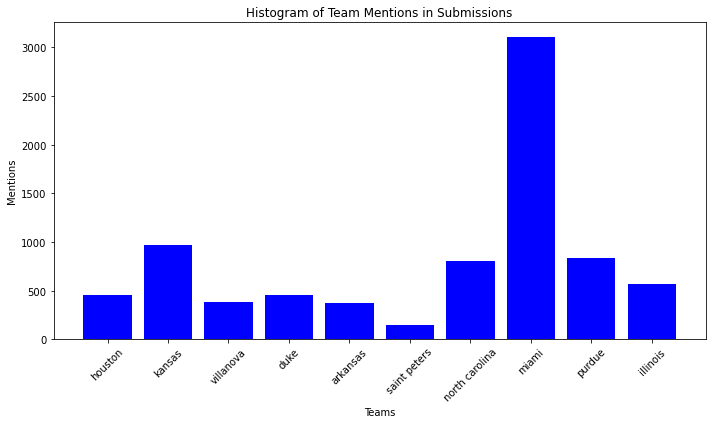

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Histogram for Submissions Counts
plt.figure(figsize=(10, 6))
plt.bar(submissions_counts_pd.columns, submissions_counts_pd.iloc[0], color='blue')
plt.title('Histogram of Team Mentions in Submissions')
plt.xlabel('Teams')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The graph presents a striking observation: Miami is mentioned markedly more often than other teams, a notably unexpected finding. Additionally, it reveals that the comment mention counts for Kansas, the 2022 champion, North Carolina, the runner-up, and the consistently strong Purdue, significantly exceed those of other teams. This aligns with typical expectations and highlights their prominence in discussions.

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 21, Finished, Available)

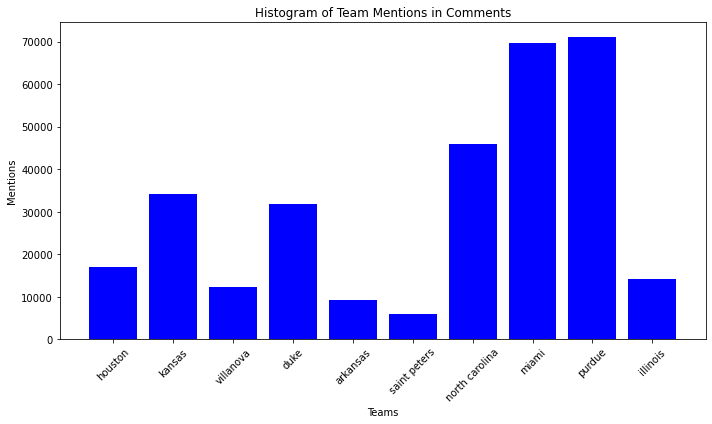

In [16]:
# Histogram for Comments Counts
plt.figure(figsize=(10, 6))
plt.bar(comments_counts_pd.columns, comments_counts_pd.iloc[0], color='blue')
plt.title('Histogram of Team Mentions in Comments')
plt.xlabel('Teams')
plt.ylabel('Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The data from the comment counts largely mirrors the trends observed in the previous figure, with a notable exception: Purdue's mentions significantly surpass those of Kansas and North Carolina, aligning them more closely with Miami's high mention frequency. This suggests a distinct level of engagement and interest in Purdue, setting it apart from the other teams.

The empirical analysis reveals a correlation between a team's number of mentions and factors like popularity and season performance. Frequently mentioned teams include top performers like Kansas, the eventual champions, and unexpected contenders like North Carolina, which aligns with our initial expectations. Intriguingly, a team like Miami, despite a lower seed ranking and only reaching the top eight, has garnered more submissions and comment mentions than even the championship team. This anomaly suggests there are additional underlying factors influencing Miami's high visibility, warranting further investigation to uncover these reasons.

### Daily Team Mentions of Submissions and Comments in `r/CollegeBasketball`

As we progress, our objective is to conduct a detailed analysis of the daily mention trends for each team. This will offer a more nuanced understanding of how audience engagement evolved over the course of the tournament. To optimize our analysis, and informed by our previous findings, we've narrowed our focus to Miami, Kansas, North Carolina, and Purdue. These four teams, having attracted a significantly higher volume of mentions, are ideal candidates for our in-depth examination of engagement patterns.

In [19]:
from pyspark.sql.functions import dayofmonth, month, year

# Aggregate the daily mention counts for each team
daily_mentions_comments = comments.groupBy(
    year("created_utc").alias("year"),
    month("created_utc").alias("month"),
    dayofmonth("created_utc").alias("day")
).agg(
    sql_sum(col('kansas').cast('int')).alias('kansas'),
    sql_sum(col('purdue').cast('int')).alias('purdue'),
    sql_sum(col('north carolina').cast('int')).alias('north_carolina'),
    sql_sum(col('miami').cast('int')).alias('miami')
)

daily_mentions_submissions = submissions.groupBy(
    year("created_utc").alias("year"),
    month("created_utc").alias("month"),
    dayofmonth("created_utc").alias("day")
).agg(
    sql_sum(col('kansas').cast('int')).alias('kansas'),
    sql_sum(col('purdue').cast('int')).alias('purdue'),
    sql_sum(col('north carolina').cast('int')).alias('north_carolina'),
    sql_sum(col('miami').cast('int')).alias('miami')
)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 24, Finished, Available)

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 25, Finished, Available)

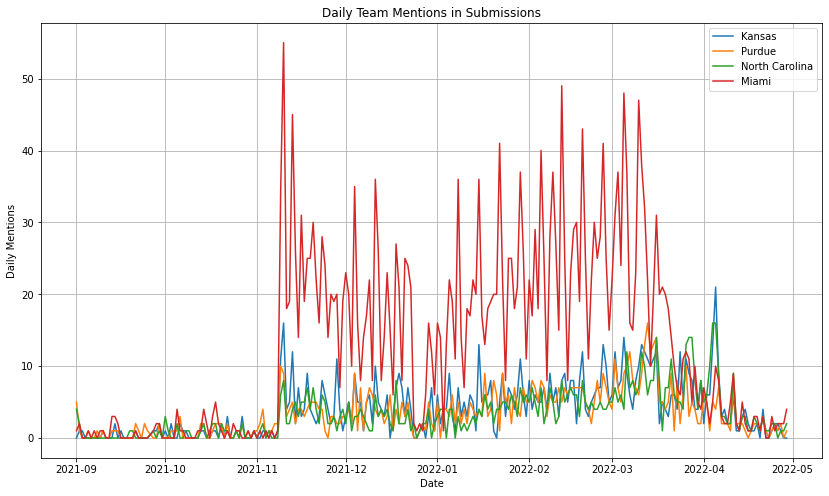

In [20]:
# Plot Daily Team Mentions in Submissions
# Convert the Spark DataFrame to a Pandas DataFrame
daily_mentions_submissions_pd = daily_mentions_submissions.toPandas()

# Convert year, month, day to a datetime object
daily_mentions_submissions_pd['date'] = pd.to_datetime(daily_mentions_submissions_pd[['year', 'month', 'day']])

# Set the 'date' column as index
daily_mentions_submissions_pd.set_index('date', inplace=True)

# Drop the year, month, and day columns
daily_mentions_submissions_pd.drop(['year', 'month', 'day'], axis=1, inplace=True)

# Sort the DataFrame by date
daily_mentions_submissions_pd.sort_index(inplace=True)

# Plot
plt.figure(figsize=(14, 8))

for column in daily_mentions_submissions_pd.columns:
    plt.plot(daily_mentions_submissions_pd.index, daily_mentions_submissions_pd[column], label=column.replace('_', ' ').title())

plt.xlabel('Date')
plt.ylabel('Daily Mentions')
plt.title('Daily Team Mentions in Submissions')
plt.legend()
plt.grid(True)
plt.show()

The chart illustrates a distinct trend: From the season's onset in November 2021 to March 2022, Miami led in commit frequency, surpassing other teams. However, a shift occurred in mid-March 2022, as Miami's commit frequency began to decline, eventually aligning with the baseline levels seen in other teams. Concurrently, there was a notable surge in submissions related to Kansas and North Carolina, culminating in a peak in early April 2022. This increase is clearly linked to their progression to the finals, reflecting heightened audience interest and engagement as these teams advanced in the tournament.

StatementMeta(7c27951d-2bdf-4140-be82-d0dc0c0e7d8e, 37, 26, Finished, Available)

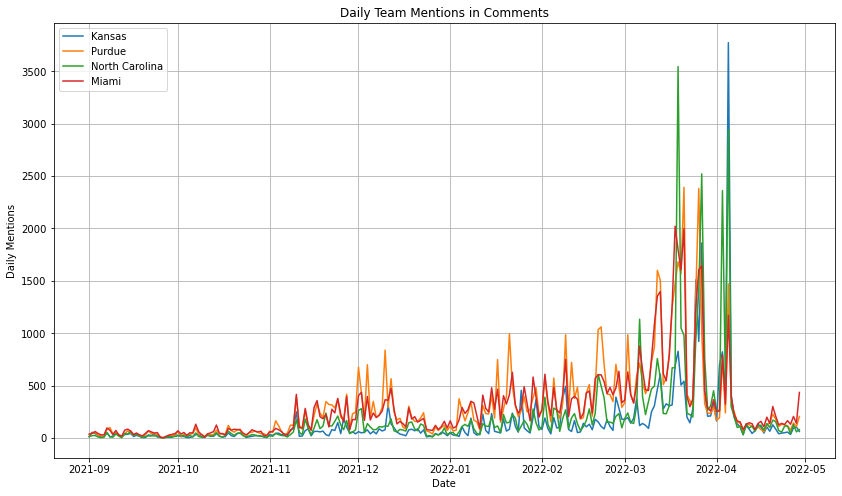

In [21]:
# Plot Daily Team Mentions in Comments
# Convert the Spark DataFrame to a Pandas DataFrame
daily_mentions_comments_pd = daily_mentions_comments.toPandas()

# Convert year, month, day to a datetime object
daily_mentions_comments_pd['date'] = pd.to_datetime(daily_mentions_comments_pd[['year', 'month', 'day']])

# Set the 'date' column as index
daily_mentions_comments_pd.set_index('date', inplace=True)

# Drop the year, month, and day columns
daily_mentions_comments_pd.drop(['year', 'month', 'day'], axis=1, inplace=True)

# Sort the DataFrame by date
daily_mentions_comments_pd.sort_index(inplace=True)

# Plot
plt.figure(figsize=(14, 8))

for column in daily_mentions_comments_pd.columns:
    plt.plot(daily_mentions_comments_pd.index, daily_mentions_comments_pd[column], label=column.replace('_', ' ').title())

plt.xlabel('Date')
plt.ylabel('Daily Mentions')
plt.title('Daily Team Mentions in Comments')
plt.legend()
plt.grid(True)
plt.show()

The data shows that while Miami and Purdue have a higher volume of daily comments, the disparity isn't as marked when compared to other teams. Both teams experienced a peak in comment activity from mid-to-late March. This trend aligns with key tournament events: Purdue's journey ended in the top 16 after their loss to St. Peter's on March 25, while Miami concluded in the top 8 following their defeat by Kansas on March 27. North Carolina's peak in comment volume around mid-March can be directly attributed to their victory over the previous year's champions, Baylor. Kansas, on the other hand, saw its comment numbers reach the highest point among all teams in early April 2022, a testament to their ultimate championship victory, drawing substantial audience engagement and discussion.

Overall, the variations in comment volume mirror the dynamics of audience engagement. As the season approaches its climax, particularly the finals, discussions intensify. The disparity in comment counts across different teams highlights the variations in their popularity and performance throughout the season. The data vividly illustrates that audience engagement peaked during critical matches, with this fervor culminating in the finals on April 4, indicating a high level of interest and involvement from fans during these pivotal moments of the tournament.